# Camera calibration matrix and distortion coefficients

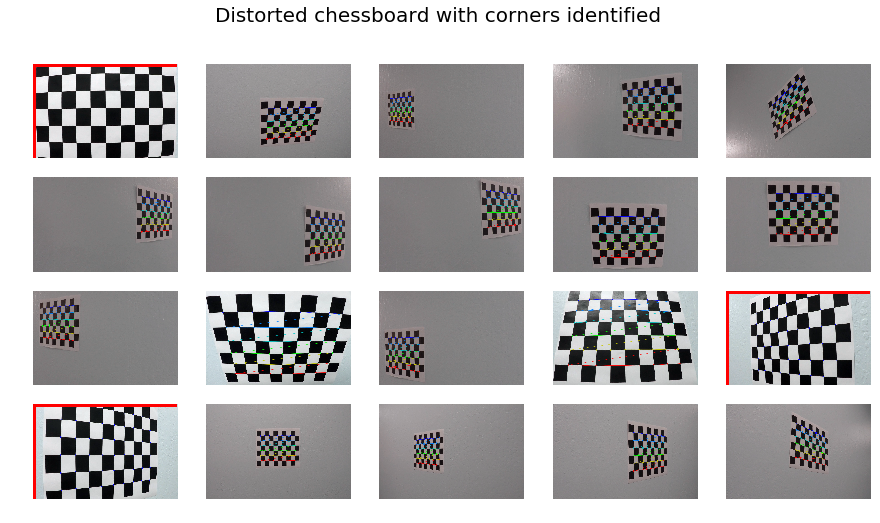

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

# Read in and make a list of calibration images
path = 'camera_cal/'
images = glob.glob(path + 'calibration*.jpg')

# Array to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 8)

for i in range(len(images)):
    # Read in each image
    img = cv2.imread(images[i])
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    # Draw and display the corners
    ax=fig.add_subplot(4,5,i+1, aspect='equal'); 
    try:
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    except:
        pass
    ax.imshow(img);
    
    if ret != True:
        ax.axhline(linewidth=5, color="r")
        ax.axvline(linewidth=5, color="r")
    
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Distorted chessboard with corners identified', fontsize = 20);

Observation: For the images marked in red, it was not possible to identify the corners of the chessboard.

## Chessboard undistorted

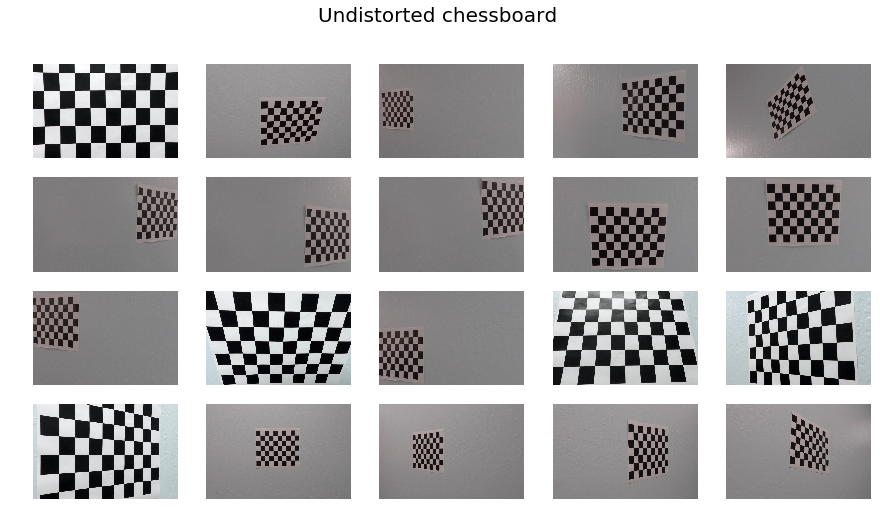

In [2]:
# Correction for distortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Function to undistort a given
def undistort_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 8)

for i in range(len(images)):
    img = cv2.imread(images[i])
    
    undist = undistort_image(img)
    
    ax=fig.add_subplot(4,5,i+1, aspect='equal'); 
    ax.imshow(undist);
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Undistorted chessboard', fontsize = 20);

## Example images undistorted

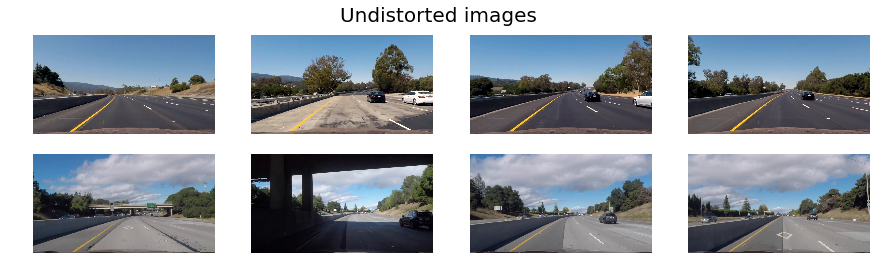

In [3]:
import os

path = "test_images//"
path = "challenge_examples//"
image_names = os.listdir(path)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 4)

for i in range(min(len(image_names), 8)):
    img = cv2.imread(path + image_names[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = undistort_image(img)
    
    ax=fig.add_subplot(2,4,i+1, aspect='equal'); 
    ax.imshow(undistorted);
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Undistorted images', fontsize = 20);

## Plot image function

In [4]:
def plot_images(img1, img2, title1, title2, colormap1, colormap2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img1, cmap=colormap1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=colormap2)
    ax2.set_title(title2, fontsize=30)
    ax1.axis('off');
    ax2.axis('off');

# Bird's-eye view

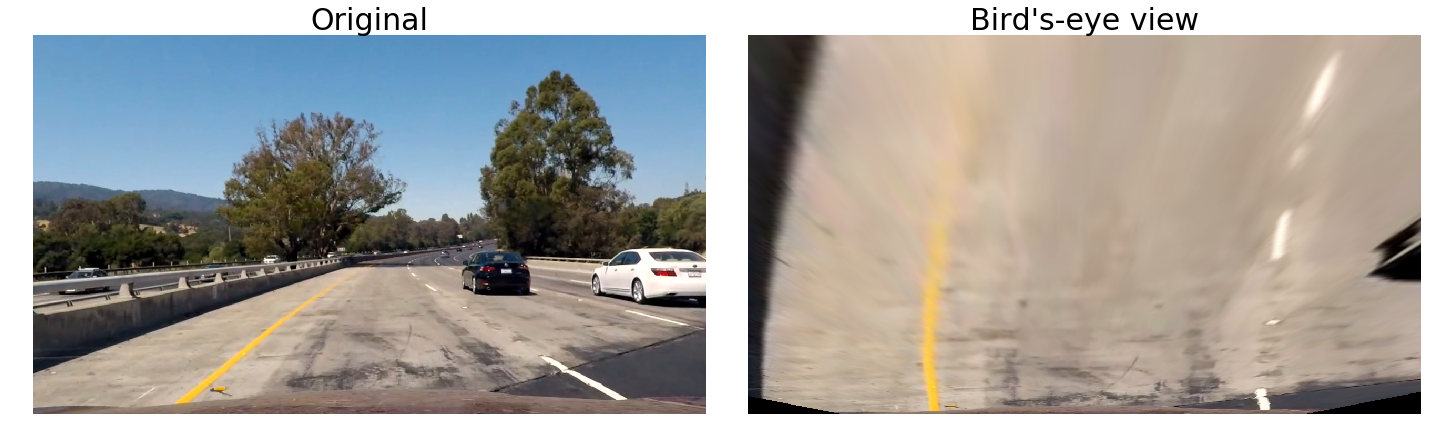

In [5]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

# Parameters
p1x = 545
p2x = 742
p3x = 1602
p4x = -261
pay = 450
pby = 720

# Perspective transfor function
def warp(img, p1x, p2x, p3x, p4x, pay, pby):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Source coordinates
    src = np.float32([[p1x, pay], [p2x, pay], [p3x, pby], [p4x, pby]])     
    
    # Desired coordinates
    dst = np.float32([[0, 0], [img_size[0], 0], [img_size[0], img_size[1]], [0, img_size[1]]])  
    
    # Perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

# Test and choose parameters
def print_image(p1x, p2x, p3x, p4x, pay, pby):
    img = cv2.imread(path + image_names[1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Undistort image
    img = undistort_image(img)
    
    # Transform
    img_warp, Minv = warp(img, p1x, p2x, p3x, p4x, pay, pby)

    # Plot
    plot_images(img, img_warp, 'Original', "Bird's-eye view", 'jet', 'jet')

interact(print_image, p1x=widgets.IntSlider(min=300,max=800,step=1,value=545),
                      p2x=widgets.IntSlider(min=400,max=1000,step=1,value=742),
                      p3x=widgets.IntSlider(min=1300,max=2000,step=1,value=1602),
                      p4x=widgets.IntSlider(min=-500,max=0,step=1,value=-261),
                      pay=widgets.IntSlider(min=200,max=700,step=1,value=450),
                      pby=widgets.IntSlider(min=300,max=1000,step=1,value=720),);

# Thresholds

## Sobel threshold

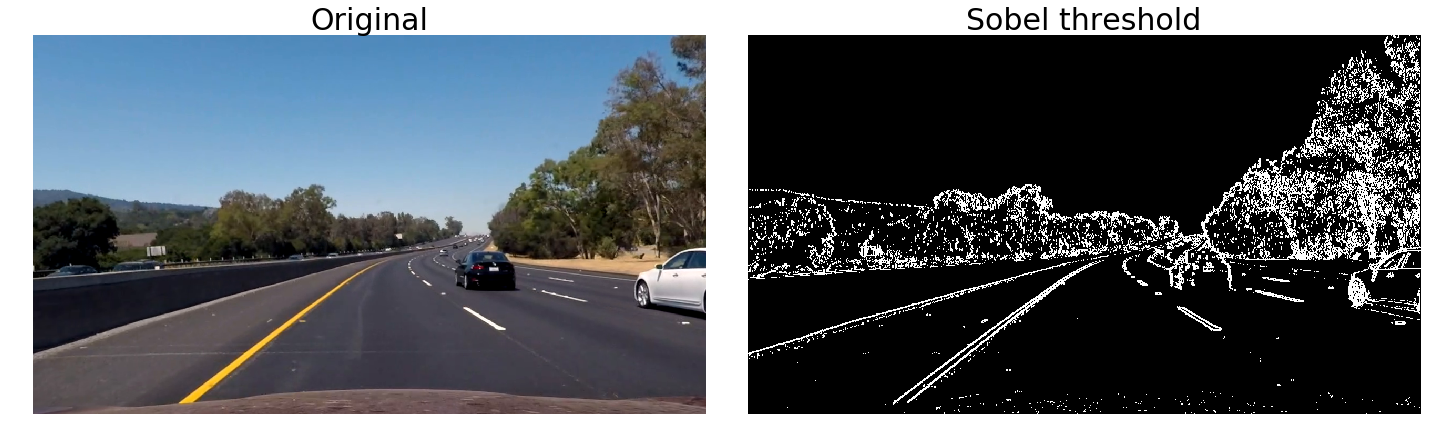

In [6]:
# Parameters
gradx_min = 10# 40
gradx_max = 160
grady_min = 96
grady_max = 255

# Absolute sobel threshold
def sobel_threshold(img, orient, thresh_min, thresh_max):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Test and choose parameters
def plot_sobel_threshold(gradx_min, gradx_max, grady_min, grady_max):
    img = cv2.imread(path + image_names[2])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Undistort image
    img = undistort_image(img)
    
    # Transform
    gradx = sobel_threshold(img, orient='x', thresh_min=gradx_min, thresh_max=gradx_max)
    grady = sobel_threshold(img, orient='y', thresh_min=grady_min, thresh_max=grady_max)

    # Combine
    combined = gradx | grady

    # Plot
    plot_images(img, combined, 'Original', "Sobel threshold", 'jet', 'gray')

interact(plot_sobel_threshold, gradx_min=widgets.IntSlider(min=0,max=255,step=1,value=gradx_min),
                                   gradx_max=widgets.IntSlider(min=0,max=255,step=1,value=gradx_max),
                                   grady_min=widgets.IntSlider(min=0,max=255,step=1,value=grady_min),
                                   grady_max=widgets.IntSlider(min=0,max=255,step=1,value=grady_max));

## Direction threshold

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobely = np.abs(sobely)
    abs_sobelx = np.abs(sobelx)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary_output

## Magnitude threshold

In [8]:
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255.0
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

## Color Threshold

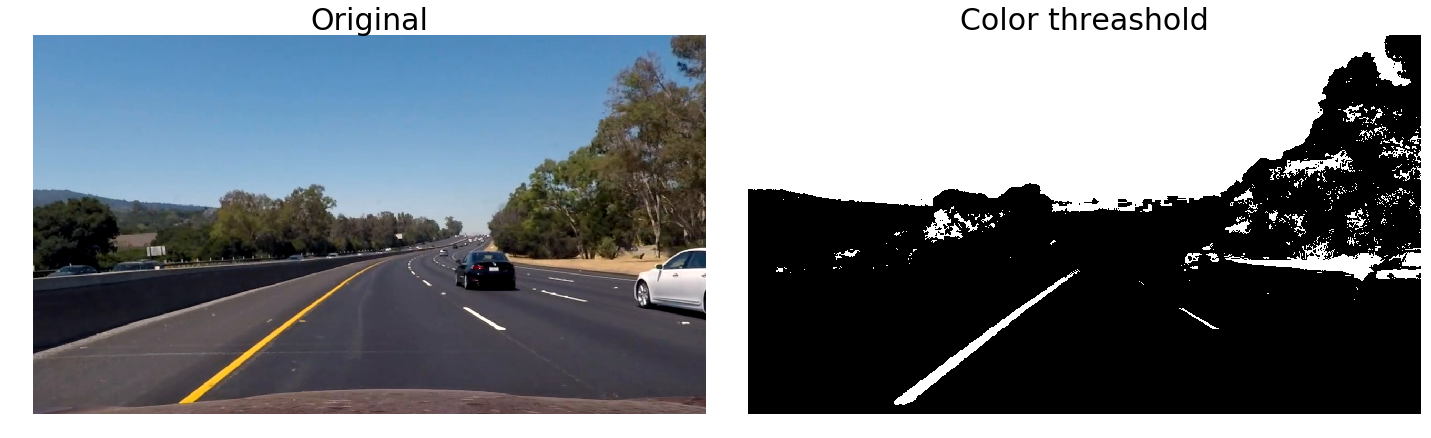

In [9]:
# Parameters
s_min = 80#120
s_max = 255
l_min = 40
l_max = 255

def color_threshold(img, s_thresh=(s_min, s_max), l_thresh=(l_min, l_max)):

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    binary = np.zeros_like(s_channel)
    binary[((l_binary == 1) & (s_binary == 1))] = 1
    binary = np.array(binary).astype('uint8')
    
    return  binary

def plot_color_threshold(s_min, s_max, l_min, l_max):
    #for image in image_names:
        img = cv2.imread(path + image_names[2])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        # Undistort image
        img = undistort_image(img)

        # Color threashold
        color = color_threshold(img, s_thresh=(s_min, s_max), l_thresh=(l_min, l_max))

        # Plot
        plot_images(img, color, 'Original', "Color threashold", 'jet', 'gray')

interact(plot_color_threshold, s_min=widgets.IntSlider(min=0,max=255,step=1,value=s_min),
                             s_max=widgets.IntSlider(min=0,max=255,step=1,value=s_max),
                             l_min=widgets.IntSlider(min=0,max=255,step=1,value=l_min),
                             l_max=widgets.IntSlider(min=0,max=255,step=1,value=l_max));

# Identify peaks

C:\Users\Ibis\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


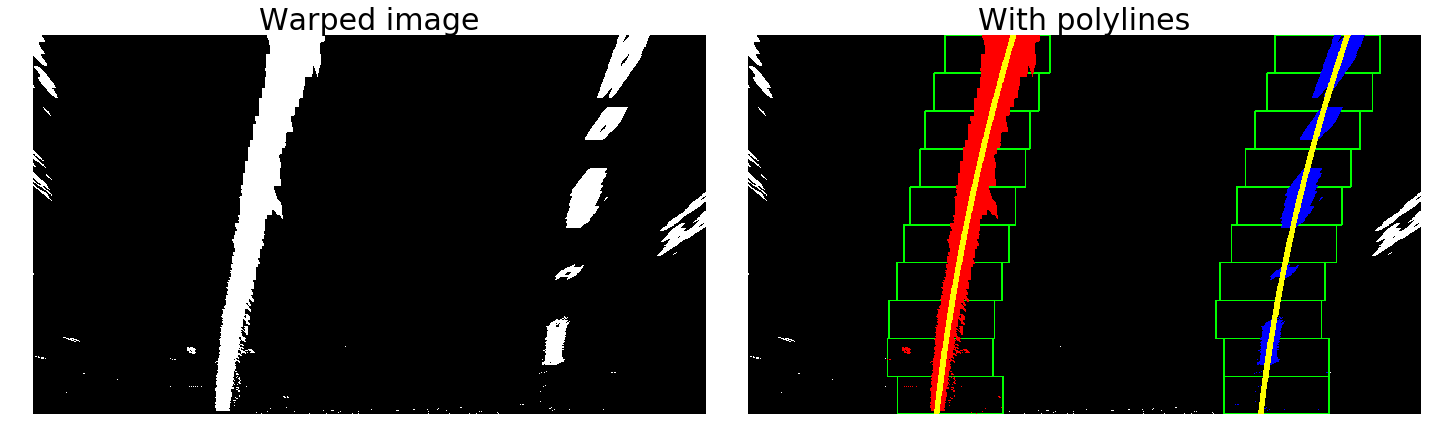

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read in an image
img = cv2.imread(path + image_names[2])

# Convert to RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Undistort image
undistorted = undistort_image(img)

# Color threashold
color = color_threshold(undistorted)

# Sobel threashold
gradx = sobel_threshold(undistorted, orient='x', thresh_min=gradx_min, thresh_max=gradx_max)
grady = sobel_threshold(undistorted, orient='y', thresh_min=grady_min, thresh_max=grady_max)

# Combine
combined = color | gradx | grady

# Warp image
img_warp, Minv = warp(combined, p1x, p2x, p3x, p4x, pay, pby)

# Shape
shape = img_warp.shape

def get_polifyt(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    middle_lane_inds = np.concatenate([left_lane_inds, right_lane_inds])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    middlex = nonzerox[middle_lane_inds]
    middley = nonzeroy[middle_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (255,255,0), thickness=10)
    cv2.polylines(out_img, [left], False, (255,255,0), thickness=10)
    
    return left_fit, right_fit, out_img

left_fit, right_fit, out_img = get_polifyt(img_warp)

plot_images(img_warp, out_img, 'Warped image', "With polylines", 'gray', 'jet')

## Radius of curvature

In [11]:
def curvature(shape, left_fit, right_fit):#lefty, leftx, righty, rightx):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, shape[0]-1, shape[0])
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate offset
    offset = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +
               (right_fit[0]*720**2+right_fit[1]*720+right_fit[2]))/2 - 1280/2)*xm_per_pix
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Build strings
    curvature = "Curvature: " + str(round((left_curverad + right_curverad)/2, 2)) + ' m'
    center_offset = "Center offset: " + str(round(offset, 2))  + ' m'
    
    return curvature, center_offset

curvature(shape, left_fit, right_fit)

('Curvature: 4134.55 m', 'Center offset: 0.14 m')

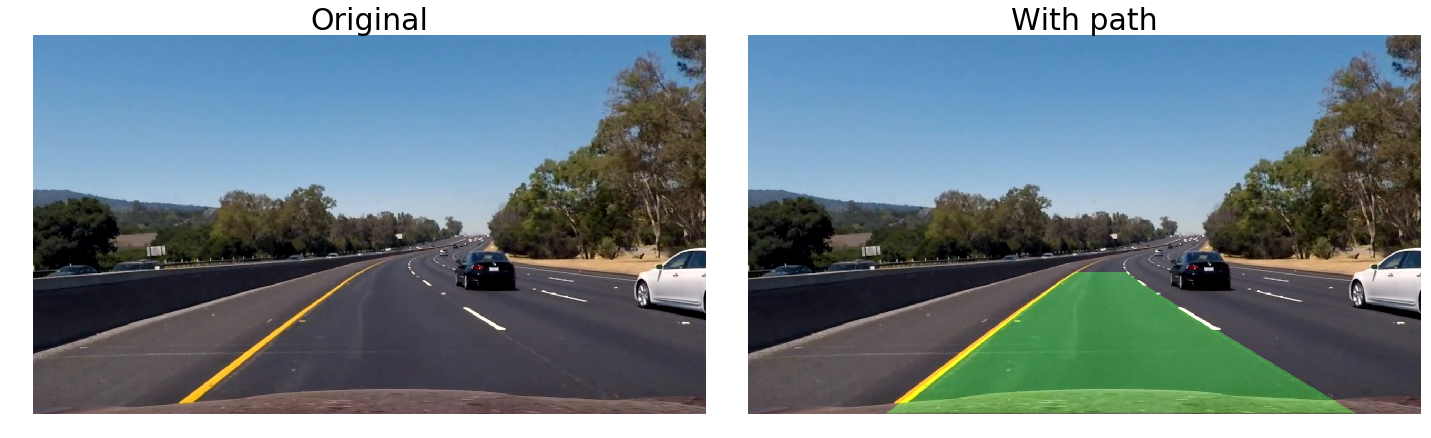

In [12]:
def draw_lines(undistorted, Minv, left_fit, right_fit):#left_fitx, right_fitx, ploty):
    # Draw the polynomial
    ploty = np.linspace(0, undistorted.shape[0]-1, undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undistorted[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    return result

result = draw_lines(undistorted, Minv, left_fit, right_fit)#, ploty)

plot_images(undistorted, result, 'Original', "With path", 'jet', 'jet')

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # # was the line detected in the last iteration?
        # self.detected = False  
        # # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        # #average x values of the fitted line over the last n iterations
        # self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # #difference in fit coefficients between last and new fits
        # self.diffs = np.array([0,0,0], dtype='float') 
        # #x values for detected line pixels
        # self.allx = None  
        # #y values for detected line pixels
        # self.ally = None
        
def save_image(data, fn):

    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])

    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(data)
    plt.savefig(fn, dpi = height)
    plt.close()

# Edit videos

In [14]:
import math

frame = 0

def process_image(img):
    global frame
    global history
    frame += 1
    line = Line()
    
    if (frame%100 == 0):
        save_image(img, 'challenge_examples\\' + 'challenge_' + str(frame))
    
    # Convert to RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Shape
    shape = img.shape
    
    # Undistort image
    undistorted = undistort_image(img)

    # Color threashold
    color = color_threshold(undistorted)
    
    # Sobel threashold
    gradx = sobel_threshold(undistorted, orient='x', thresh_min=gradx_min, thresh_max=gradx_max)
    grady = sobel_threshold(undistorted, orient='y', thresh_min=grady_min, thresh_max=grady_max)
    
    # Combine
    combined = color | gradx | grady
    
    # Warp image
    img_warp, Minv = warp(combined, p1x, p2x, p3x, p4x, pay, pby)
    
    # Get polynomial
    left_fit, right_fit, out_img = get_polifyt(img_warp)
    line.current_fit = [left_fit, right_fit]
    
    # Get curvature
    line.radius_of_curvature, line.line_base_pos = curvature(shape, left_fit, right_fit)
    
    # Draw lines on image
    result = draw_lines(undistorted, Minv, left_fit, right_fit)
    
    # Define output image
    # Main image
    img_out=np.zeros((720,1707,3), dtype=np.uint8)
    img_out[0:720,0:1280,:] = result
    
    # Text formatting
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    
    # Bird's-eye view image
    img_warpp, _ = warp(undistorted, p1x, p2x, p3x, p4x, pay, pby)
    img_out[0:240,1281:1707,:] = cv2.resize(img_warpp,(426,240))
    boxsize, _ = cv2.getTextSize("Bird's-eye view", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Bird's-eye view", (int(1494-boxsize[0]/2),40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
   
    # Combined image
    resssized = cv2.resize(combined,(426,240))
    gray_image = cv2.cvtColor(resssized*255,cv2.COLOR_GRAY2RGB)
    img_out[241:481,1281:1707,:] = cv2.resize(gray_image,(426,240))
    boxsize, _ = cv2.getTextSize("Threshold image", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Threshold image", (int(1494-boxsize[0]/2),281), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
 
    # Polynomial lines
    img_out[480:720,1281:1707,:] = cv2.resize(out_img,(426,240))
    boxsize, _ = cv2.getTextSize("Polynomial lines", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Polynomial lines", (int(1494-boxsize[0]/2),521), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    # Put text
    if ((len(history)+1)%10 == 0) or len(history) == 0:
        curv = line.radius_of_curvature
        center_offset = line.line_base_pos
    else:
        last_integer = max(math.floor((len(history)) / 10) * 10 - 1,0)
        curv = history[last_integer].radius_of_curvature
        center_offset = history[last_integer].line_base_pos
    cv2.putText(img_out, curv, (40,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, center_offset, (40,80), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    # Convert to BGR
    result = cv2.cvtColor(img_out,cv2.COLOR_RGB2BGR)
    
    history.append(line)
    
    return result

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = []

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_output, audio=False)

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:35<00:00,  4.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 36s


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = []

project_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_output, audio=False)

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████| 485/485 [01:41<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 43s
